In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import time

tf.enable_eager_execution()
tf.__version__

/home/ssojux2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ssojux2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ssojux2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ssojux2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

'1.14.0'

In [2]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
x_train_words = ['good', 'bad', 'amazing', 'so good', 'bull shit',
                 'awesome', 'how dare', 'very much', 'nice', 'god damn it',
                 'very very very happy', 'what the fuck']
y_train = np.array([0, 1, 0, 0, 1,
                    0, 1, 0, 0, 1,
                    0, 1], dtype=np.int32)

In [4]:
# positive sample
index = 0
print("word: {}\nlabel: {}".format(x_train_words[index], y_train[index]))

word: good
label: 0


In [5]:
# negative sample
index = 1
print("word: {}\nlabel: {}".format(x_train_words[index], y_train[index]))

word: bad
label: 1


In [6]:
tokenizer = Tokenizer(char_level=True)

In [7]:
tokenizer.fit_on_texts(x_train_words)

In [8]:
num_chars = len(tokenizer.word_index) + 1
print("number of characters: {}".format(num_chars))

number of characters: 25


In [9]:
tokenizer.word_index

{' ': 1,
 'e': 2,
 'o': 3,
 'a': 4,
 'd': 5,
 'h': 6,
 'r': 7,
 'y': 8,
 'g': 9,
 'm': 10,
 'i': 11,
 't': 12,
 'v': 13,
 'n': 14,
 's': 15,
 'u': 16,
 'w': 17,
 'c': 18,
 'b': 19,
 'l': 20,
 'p': 21,
 'z': 22,
 'f': 23,
 'k': 24}

In [10]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_words)

In [11]:
index = 2
print("text: {}".format(x_train_words[index]))
print("token: {}".format(x_train_tokens[index]))

text: amazing
token: [4, 10, 4, 22, 11, 14, 9]


In [12]:
x_train_seq_length = np.array([len(tokens) for tokens in x_train_tokens], dtype=np.int32)
num_seq_length = x_train_seq_length

In [13]:
max_seq_length = np.max(num_seq_length)
print(max_seq_length)

20


In [14]:
pad = 'pre'
#pad = 'post'

In [15]:
x_train_pad = pad_sequences(sequences=x_train_tokens, maxlen=max_seq_length,
                            padding=pad, truncating=pad)

In [16]:
index = 7
print("text: {}\n".format(x_train_words[index]))
print("token: {}\n".format(x_train_tokens[index]))
print("pad: {}".format(x_train_pad[index]))

text: very much

token: [13, 2, 7, 8, 1, 10, 16, 18, 6]

pad: [ 0  0  0  0  0  0  0  0  0  0  0 13  2  7  8  1 10 16 18  6]


In [17]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))
print(inverse_map)

{1: ' ', 2: 'e', 3: 'o', 4: 'a', 5: 'd', 6: 'h', 7: 'r', 8: 'y', 9: 'g', 10: 'm', 11: 'i', 12: 't', 13: 'v', 14: 'n', 15: 's', 16: 'u', 17: 'w', 18: 'c', 19: 'b', 20: 'l', 21: 'p', 22: 'z', 23: 'f', 24: 'k'}


In [18]:
def tokens_to_string(tokens):
  # Map from tokens back to words.
  words = [inverse_map[token] for token in tokens if token != 0]

  # Concatenate all words.
  text = "".join(words)

  return text

In [19]:
index = 10
print("original text:\n{}\n".format(x_train_words[index]))
print("tokens to string:\n{}".format(tokens_to_string(x_train_tokens[index])))

original text:
very very very happy

tokens to string:
very very very happy


In [20]:
# Set the hyperparameter set
batch_size = 4
max_epochs = 50
#embedding_size = 8
num_units = 16 # the number of nodes in RNN hidden layer
num_classes = 2 # Two classes [True, False]
initializer_scale = 0.1
learning_rate = 1e-3

In [21]:
## create data pipeline with tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_pad, x_train_seq_length, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 100)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

<DatasetV1Adapter shapes: ((?, 20), (?,), (?,)), types: (tf.int32, tf.int32, tf.int32)>


In [22]:
model = tf.keras.Sequential([
          layers.Embedding(num_chars, num_chars, embeddings_initializer='identity', trainable=False),
          layers.SimpleRNN(units=num_units),
          layers.Dense(units=num_classes)])

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate)
loss_history = []

In [24]:
total_steps = int( len(x_train_words) / batch_size * max_epochs)
for (step, (seq_pad, seq_length, labels)) in enumerate(train_dataset.take(total_steps)): # just steps number (iterations), NOT epochs
  start_time = time.time()
  with tf.GradientTape() as tape:
    logits = model(seq_pad)    
    loss_value = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.one_hot(labels, depth=num_classes),
                                                 logits=logits)
    

  loss_history.append(loss_value.numpy())
  grads = tape.gradient(loss_value, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables),
                            global_step=tf.train.get_or_create_global_step())
  
  if step % 3 == 0:
      clear_output(wait=True)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      epochs = batch_size * step / float(len(x_train_words))
      print("epochs: {:.2f}, step: {}, loss: {:g}, ({:.2f} examples/sec; {:.3f} sec/batch)".format(epochs+1, step, loss_value, examples_per_sec, duration))
    
print("training done!")

epochs: 50.00, step: 147, loss: 0.117598, (140.02 examples/sec; 0.029 sec/batch)
training done!


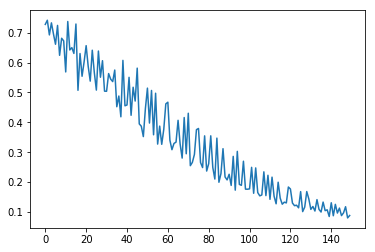

In [25]:
loss_history = np.array(loss_history)
plt.plot(loss_history, label='train')

In [26]:
train_dataset_eval = tf.data.Dataset.from_tensor_slices((x_train_pad, x_train_seq_length, y_train))
train_dataset_eval = train_dataset_eval.batch(batch_size = len(x_train_pad))

In [27]:
accuracy = tf.contrib.eager.metrics.Accuracy()

for (step, (seq_pad, seq_length, labels)) in enumerate(train_dataset.take(1)):
  logits = model(seq_pad)
  accuracy(labels=labels, predictions=tf.cast(tf.argmax(logits, 1), tf.int32))
  
print("test accuracy: {}".format(accuracy.result()))

W0830 13:19:53.486512 139738007406400 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



test accuracy: 1.0


In [28]:
for (step, (seq_pad, seq_length, labels)) in enumerate(train_dataset_eval.take(1)):
  logits = model(seq_pad)
  predictions = tf.cast(tf.argmax(logits, 1), tf.int32)

In [29]:
predictions

<tf.Tensor: id=108682, shape=(12,), dtype=int32, numpy=array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int32)>

In [30]:
for x, y in zip(seq_pad, predictions):
  if y.numpy() == 0:
    print("{} : positive".format(tokens_to_string(x.numpy())))
  else:
    print("{} : negative".format(tokens_to_string(x.numpy())))

good : positive
bad : negative
amazing : positive
so good : positive
bull shit : negative
awesome : positive
how dare : negative
very much : positive
nice : positive
god damn it : negative
very very very happy : positive
what the fuck : negative
